In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15002, done.
remote: Total 15002 (delta 0), reused 0 (delta 0), pack-reused 15002
Receiving objects: 100% (15002/15002), 14.02 MiB | 2.84 MiB/s, done.
Resolving deltas: 100% (10291/10291), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.9 MB/s eta 0:00:00


In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import ops
from shapely.geometry import box, Polygon
import cv2

random.seed(108)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir annotations
# Function to extract from csv
def extract_info_from_csv(path):
  df = pd.read_csv(path)
  # Initialise the info dict 
  for name,box in df.itertuples(index=False):
    print_buffer = []
    b = box[1:-1].split(',')
    for j in range(4):
      b_center_x = float(b[2*j])
      b_center_y = float(b[2*j+1])
      b_width = (max(float(b[2]),float(b[4])) - min(float(b[0]),float(b[6])))/15
      b_height   = (max(float(b[7]),float(b[5])) - min(float(b[1]),float(b[3])))/15
      # b_center_x = float(b[4])
      # b_center_y = float(b[5])
      # b_width = (max(float(b[2]),float(b[4])) - min(float(b[0]),float(b[6])))/15
      # b_height   = (max(float(b[7]),float(b[5])) - min(float(b[1]),float(b[3])))/15
      # b_center_x = (min(float(b[0]),float(b[6])) + max(float(b[2]),float(b[4]))) / 2 
      # b_center_y = (min(float(b[1]),float(b[3])) + max(float(b[7]),float(b[5]))) / 2 
      # b_width    = (max(float(b[2]),float(b[4])) - min(float(b[0]),float(b[6])))
      # b_height   = (max(float(b[7]),float(b[5])) - min(float(b[1]),float(b[3])))
      # Normalise the co-ordinates by the dimensions of the image
      image_w = 1280
      image_h = 720  
      b_center_x /= image_w 
      b_center_y /= image_h 
      b_width    /= image_w 
      b_height   /= image_h
      print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(j, b_center_x, b_center_y, b_width, b_height))
    # Name of the file which we have to save 
    ! cd annotations
    save_file_name = os.path.join("annotations", name.replace("jpeg", "txt"))

    # Save the annotation to disk
    #! touch "annotations/save_file_name.txt"
    print("\n".join(print_buffer), file=open(save_file_name, "w"))

print(extract_info_from_csv('/content/drive/MyDrive/Step-1/labels.csv'))

None


In [ ]:
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

In [ ]:
!cp -av "/content/drive/MyDrive/Step-1/images" "/content"

'/content/drive/MyDrive/Step-1/images' -> '/content/images'
'/content/drive/MyDrive/Step-1/images/medicakolkata_ccu2_mon--7_2022_6_8_1_6_57.jpeg' -> '/content/images/medicakolkata_ccu2_mon--7_2022_6_8_1_6_57.jpeg'
'/content/drive/MyDrive/Step-1/images/hcgnagpur_icu_mon--8_2022_6_20_4_31_9.jpeg' -> '/content/images/hcgnagpur_icu_mon--8_2022_6_20_4_31_9.jpeg'
'/content/drive/MyDrive/Step-1/images/medicakolkata_ccu3_mon--3_2022_6_8_21_3_8.jpeg' -> '/content/images/medicakolkata_ccu3_mon--3_2022_6_8_21_3_8.jpeg'
'/content/drive/MyDrive/Step-1/images/medicakolkata_ccu3_mon--3_2022_5_30_1_2_51.jpeg' -> '/content/images/medicakolkata_ccu3_mon--3_2022_5_30_1_2_51.jpeg'
'/content/drive/MyDrive/Step-1/images/medicakolkata_ccu1_mon--7_2022_6_8_12_1_16.jpeg' -> '/content/images/medicakolkata_ccu1_mon--7_2022_6_8_12_1_16.jpeg'
'/content/drive/MyDrive/Step-1/images/hcgnagpur_icu_mon--3_2022_5_18_4_30_28.jpeg' -> '/content/images/hcgnagpur_icu_mon--3_2022_5_18_4_30_28.jpeg'
'/content/drive/MyDrive/St

[[0.    0.285 0.218 0.023 0.03 ]
 [1.    0.623 0.234 0.023 0.03 ]
 [2.    0.611 0.673 0.023 0.03 ]
 [3.    0.276 0.656 0.023 0.03 ]]
[[  0.   364.8  156.96  29.44  21.6 ]
 [  1.   797.44 168.48  29.44  21.6 ]
 [  2.   782.08 484.56  29.44  21.6 ]
 [  3.   353.28 472.32  29.44  21.6 ]]


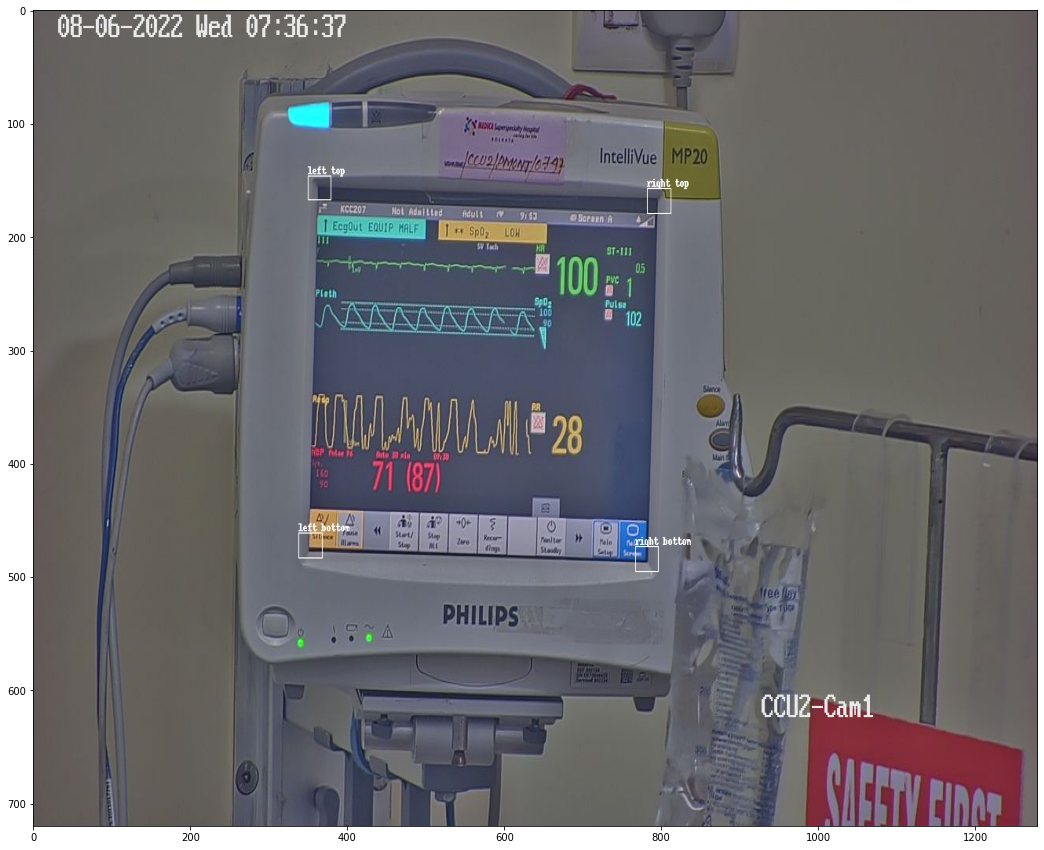

In [ ]:
random.seed(1)
columns=['left top', 'right top', 'right bottom', 'left bottom']
# class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h
    print(transformed_annotations)
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), columns[int(obj_cls)])
    
    plt.figure(figsize = (18,15))
    plt.imshow(np.array(image),aspect='auto')
    plt.show()
    # plt.imshow(np.array(image))
    # plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpeg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
!cp -r /content/annotations /content/labels

In [ ]:
! cd yolov5/utils
!python /content/yolov5/train.py --img 640 --cfg /content/yolov5/data/yolov5s.yaml --hyp /content/yolov5/data/hyp.scratch.yaml --batch 32 --epochs 100 --data /content/yolov5/data/screen.yaml --weights '' --workers 24 --name yolo_road_det

train: weights=, cfg=/content/yolov5/data/yolov5s.yaml, data=/content/yolov5/data/screen.yaml, hyp=/content/yolov5/data/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolo_road_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=

In [ ]:
!cp -av "/content/yolov5/runs/train/yolo_road_det" "/content/drive/MyDrive/weightsCornerExtraction"

'/content/yolov5/runs/train/yolo_road_det' -> '/content/drive/MyDrive/weightsCornerExtraction'
'/content/yolov5/runs/train/yolo_road_det/weights' -> '/content/drive/MyDrive/weightsCornerExtraction/weights'
'/content/yolov5/runs/train/yolo_road_det/weights/last.pt' -> '/content/drive/MyDrive/weightsCornerExtraction/weights/last.pt'
'/content/yolov5/runs/train/yolo_road_det/weights/best.pt' -> '/content/drive/MyDrive/weightsCornerExtraction/weights/best.pt'
'/content/yolov5/runs/train/yolo_road_det/hyp.yaml' -> '/content/drive/MyDrive/weightsCornerExtraction/hyp.yaml'
'/content/yolov5/runs/train/yolo_road_det/opt.yaml' -> '/content/drive/MyDrive/weightsCornerExtraction/opt.yaml'
'/content/yolov5/runs/train/yolo_road_det/events.out.tfevents.1674921513.d9be50901d3f.7780.0' -> '/content/drive/MyDrive/weightsCornerExtraction/events.out.tfevents.1674921513.d9be50901d3f.7780.0'
'/content/yolov5/runs/train/yolo_road_det/labels_correlogram.jpg' -> '/content/drive/MyDrive/weightsCornerExtraction/

In [ ]:
!python /content/yolov5/detect.py -h

usage: detect.py
       [-h]
       [--weights WEIGHTS [WEIGHTS ...]]
       [--source SOURCE]
       [--data DATA]
       [--imgsz IMGSZ [IMGSZ ...]]
       [--conf-thres CONF_THRES]
       [--iou-thres IOU_THRES]
       [--max-det MAX_DET]
       [--device DEVICE]
       [--view-img]
       [--save-txt]
       [--save-conf]
       [--save-crop]
       [--nosave]
       [--classes CLASSES [CLASSES ...]]
       [--agnostic-nms]
       [--augment]
       [--visualize]
       [--update]
       [--project PROJECT]
       [--name NAME]
       [--exist-ok]
       [--line-thickness LINE_THICKNESS]
       [--hide-labels]
       [--hide-conf]
       [--half]
       [--dnn]
       [--vid-stride VID_STRIDE]

optional arguments:
  -h, --help
    show this
    help
    message and
    exit
  --weights WEIGHTS [WEIGHTS ...]
    model path
    or triton
    URL
  --source SOURCE
    file/dir/UR
    L/glob/scre
    en/0(webcam
    )
  --data DATA
    (optional) 
    dataset.yam
    l path
  --imgsz I

In [ ]:
!python /content/yolov5/detect.py --source /content/images/test --weights /content/drive/MyDrive/weightsCornerExtraction/weights/best.pt --save-txt --save-conf --conf 0.25 --name yolo_road_det3

detect: weights=['/content/drive/MyDrive/weightsCornerExtraction/weights/best.pt'], source=/content/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_road_det3, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
YOLOv5s summary: 166 layers, 7062001 parameters, 0 gradients
image 1/200 /content/images/test/hcgbhavnagar_micu_mon--403_2022_5_18_11_20_1.jpeg: 384x640 1 left top, 1 right top, 1 right bottom, 1 left bottom, 275.0ms
image 2/200 /content/images/test/hcgbhavnagar_micu_mon--403_2022_5_18_17_20_1.jpeg: 384x640 1 left top, 1 right top, 1 right bottom, 1 left bottom, 271.1ms
image 3/200 /c

In [ ]:
!cp -av "/content/yolov5/runs/detect/yolo_road_det32" "/content/drive/MyDrive/resultCornerExtraction2"

'/content/yolov5/runs/detect/yolo_road_det32' -> '/content/drive/MyDrive/resultCornerExtraction2'
'/content/yolov5/runs/detect/yolo_road_det32/labels' -> '/content/drive/MyDrive/resultCornerExtraction2/labels'
'/content/yolov5/runs/detect/yolo_road_det32/labels/hcgbhavnagar_micu_mon--403_2022_5_18_11_20_1.txt' -> '/content/drive/MyDrive/resultCornerExtraction2/labels/hcgbhavnagar_micu_mon--403_2022_5_18_11_20_1.txt'
'/content/yolov5/runs/detect/yolo_road_det32/labels/hcgbhavnagar_micu_mon--403_2022_5_18_17_20_1.txt' -> '/content/drive/MyDrive/resultCornerExtraction2/labels/hcgbhavnagar_micu_mon--403_2022_5_18_17_20_1.txt'
'/content/yolov5/runs/detect/yolo_road_det32/labels/hcgbhavnagar_micu_mon--404_2022_6_8_13_20_1.txt' -> '/content/drive/MyDrive/resultCornerExtraction2/labels/hcgbhavnagar_micu_mon--404_2022_6_8_13_20_1.txt'
'/content/yolov5/runs/detect/yolo_road_det32/labels/hcgnagpur_icu_mon--1_2022_6_20_18_30_1.txt' -> '/content/drive/MyDrive/resultCornerExtraction2/labels/hcgnagpu

# IOU

open and preprocess the txt files

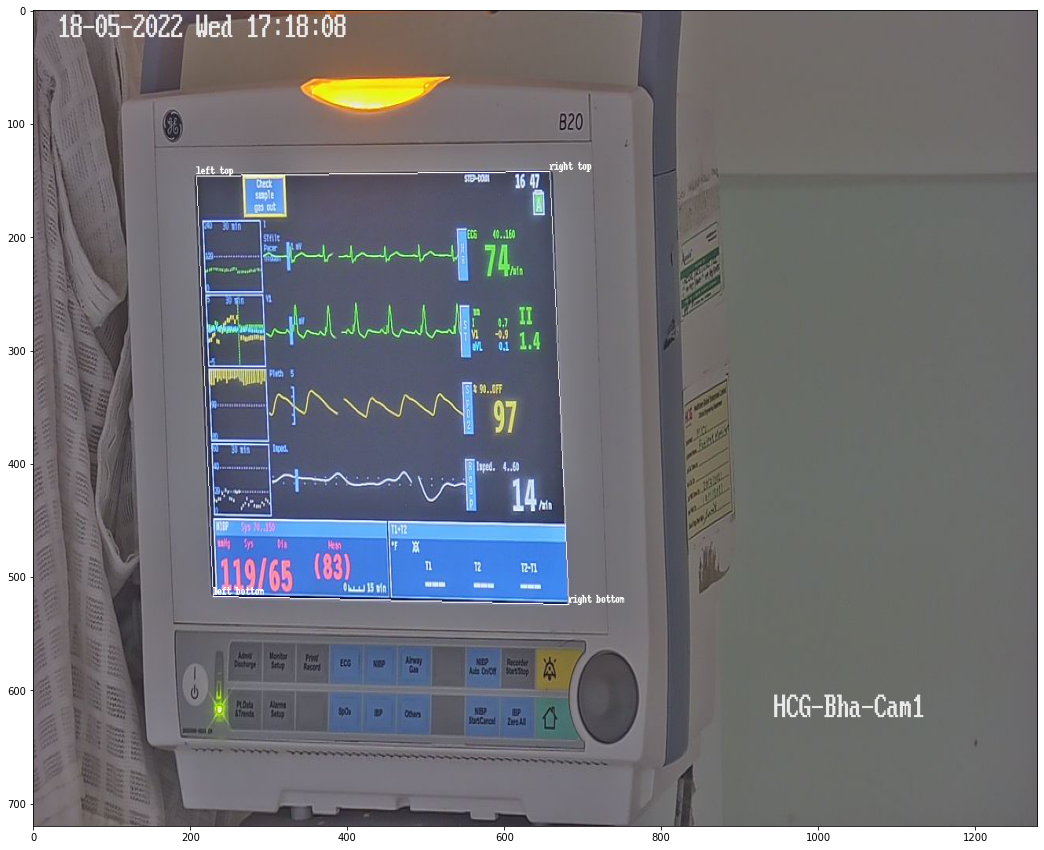

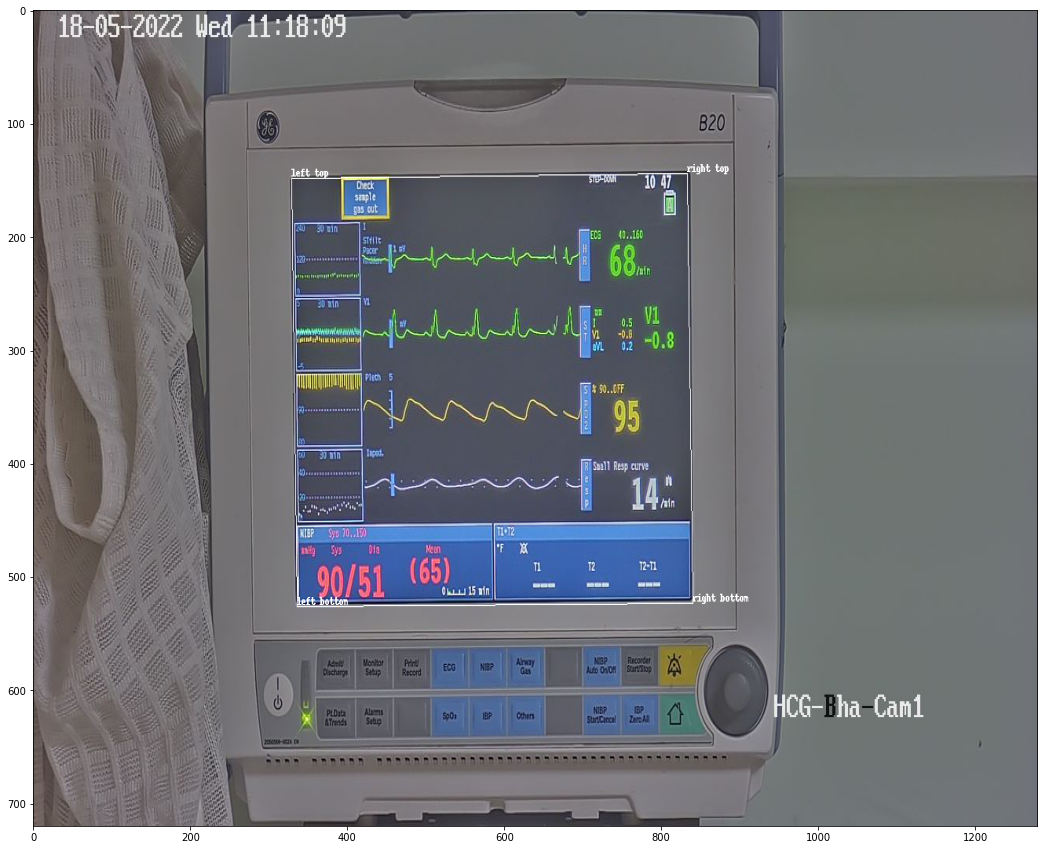

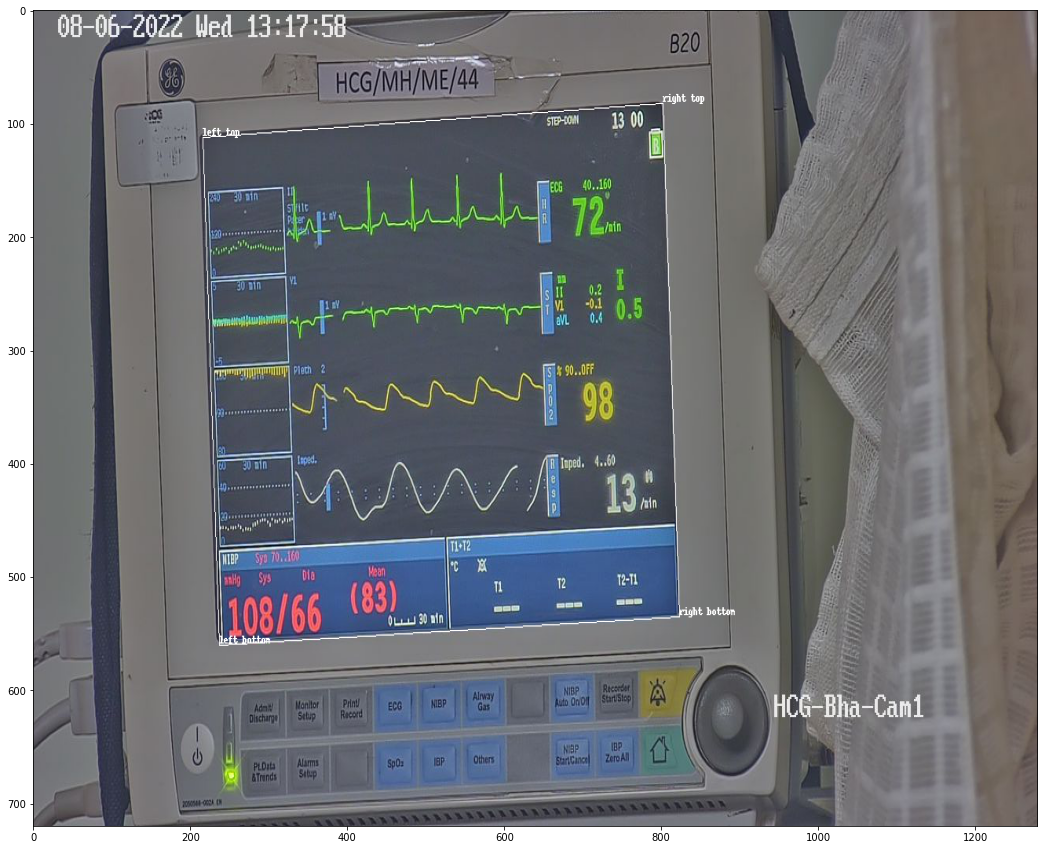

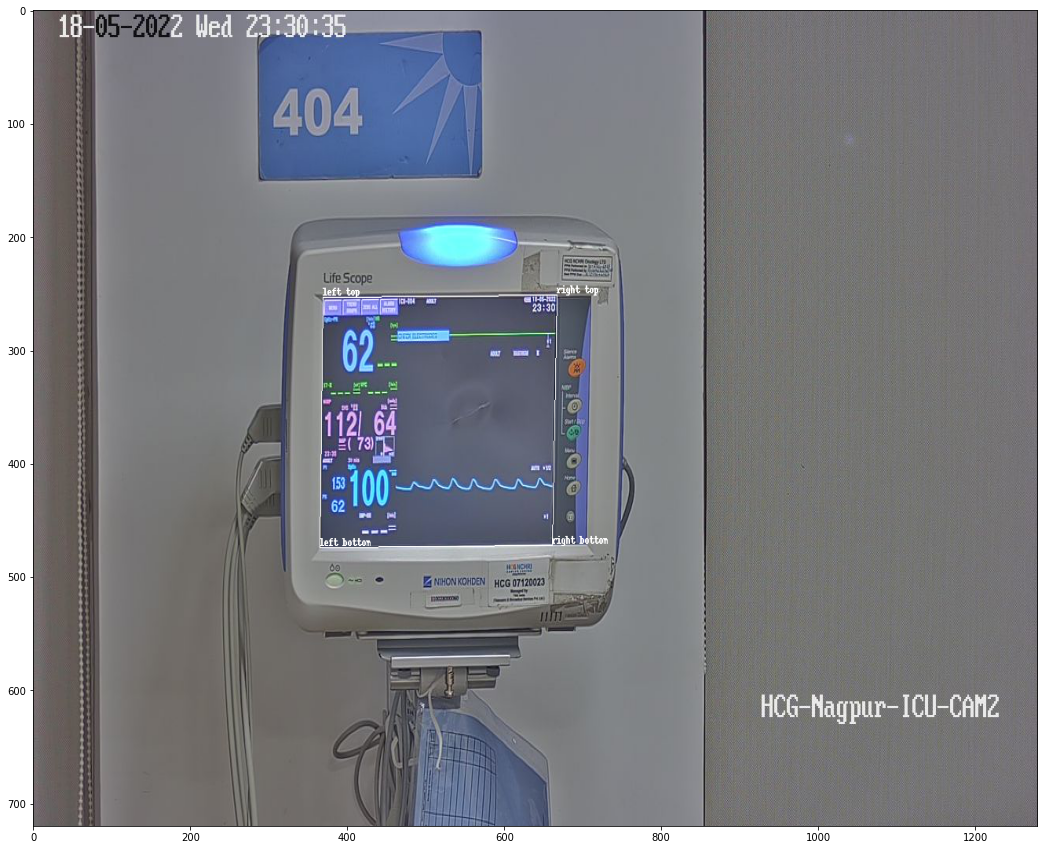

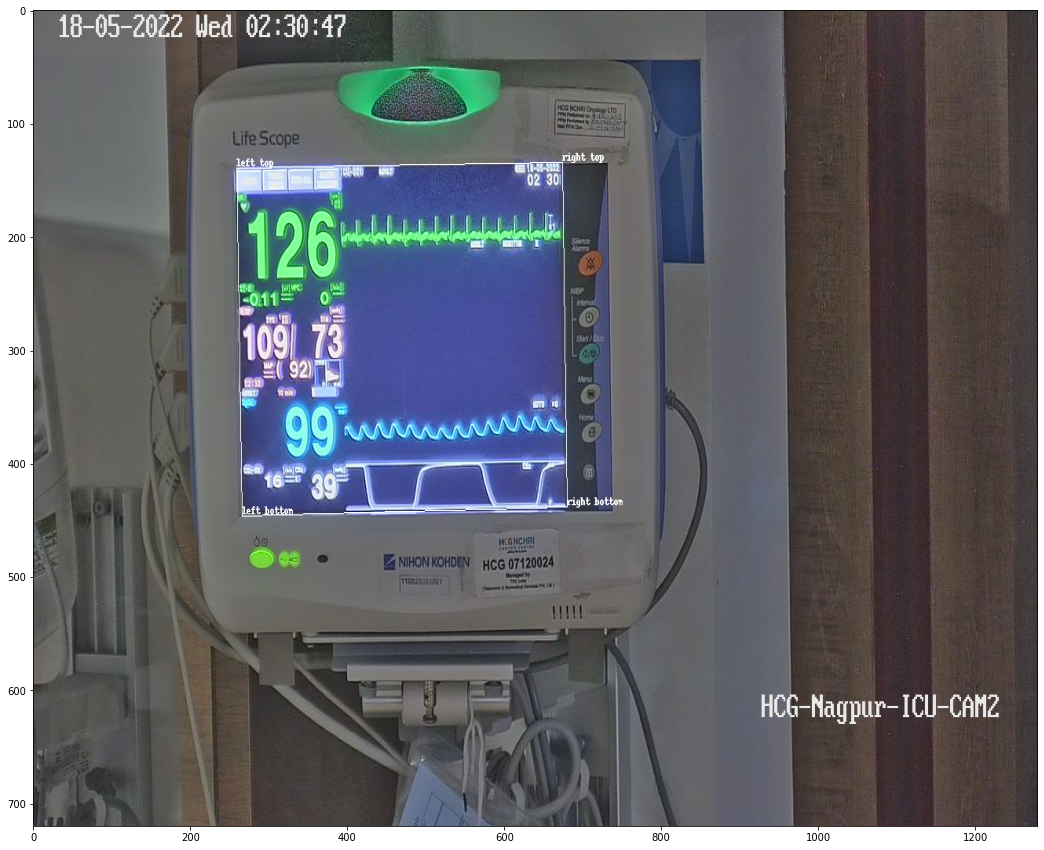

In [2]:
# for file in os.listdir("/content/yolov5/runs/detect/yolo_road_det32/labels")[:5]:
#   if file[-3:]=='txt':
#     with open(file, "r") as file:
#       annotation_list = file.read().split("\n")[:-1]
#       annotation_list = [x.split(" ") for x in annotation_list]
#       annotation_list = [[float(y) for y in x ] for x in annotation_list]
#       print(annotation_list)
def remove_dublicate_corners(thelist):
  # print("found1case",thelist)
  ans=[]
  visited=[-1,-1,-1,-1]
  index=0
  for set1 in thelist:
    # check if that corner has been stored or not
    if visited[int(set1[0])] != -1:
      # compare the probabilities and take the one with max P
      if ans[visited[int(set1[0])]][-1]< set1[-1]:
        ans[visited[int(set1[0])]]=set1
    else:
      visited[int(set1[0])] = index
      index=index+1
      ans.append(set1)
  # print(thelist)
  # print(ans)
  # print(" ")
  return ans

columns_list=['left top', 'right top', 'right bottom', 'left bottom']
def extract_box_info(path_to_file):
  with open(path_to_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
    annotation_list = sorted(annotation_list,key=lambda l:l[0])
    if len(annotation_list)>4:
      annotation_list=remove_dublicate_corners(annotation_list)
    return annotation_list
df_predicted = pd.DataFrame(columns = ['Name', 'Coordinates'])

def croptheimage(image_file,box_info):
  global df_predicted
  w, h = Image.open(image_file).size
  # plotted_image = ImageDraw.Draw(image_file)
  # print('box info',box_info)
  # for annotation_list in box_info:
  annotations = np.array(box_info)
  transformed_annotations = np.copy(annotations)
  # print(transformed_annotations)
  transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
  transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h
  # print(transformed_annotations)
  
  # transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
  # transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
  # transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
  # transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
  
  # for ann in transformed_annotations:
    
  # rectangle(((x0,y0), (x1,y1)))
  coordinates_for_csv=transformed_annotations[:,1:3].flatten()
  # plotted_image.polygon(transformed_annotations[:,1:3].flatten().tolist())

  # trying something totally crazy
  img = cv2.imread(image_file)
  mask = np.zeros(img.shape[0:2], dtype=np.uint8)
  # points = np.array([[[100,350],[120,400],[310,350],[360,200],[350,20],[25,120]]])
  points=transformed_annotations[:,1:3]
  #method 1 smooth region
  print(points.shape)
  cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)
  #method 2 not so smooth region
  # cv2.fillPoly(mask, points, (255))
  res = cv2.bitwise_and(img,img,mask = mask)
  rect = cv2.boundingRect(points) # returns (x,y,w,h) of the rect
  cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
  ## crate the white background of the same size of original image
  wbg = np.ones_like(img, np.uint8)*255
  cv2.bitwise_not(wbg,wbg, mask=mask)
  # overlap the resulted cropped image on the white background
  dst = wbg+res
  cv2.imshow('Original',img)
  cv2.imshow("Mask",mask)
  cv2.imshow("Cropped", cropped )
  cv2.imshow("Samed Size Black Image", res)
  cv2.imshow("Samed Size White Image", dst)
  cv2.waitKey(0)
  cv2.destroyAllWindows()


def plot_bounding_parallelogram (image_file,box_info):
  global df_predicted
  w, h = image_file.size
  plotted_image = ImageDraw.Draw(image_file)
  # print('box info',box_info)
  # for annotation_list in box_info:
  annotations = np.array(box_info)
  transformed_annotations = np.copy(annotations)
  # print(transformed_annotations)
  transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
  transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h
  # print(transformed_annotations)
  
  # transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
  # transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
  # transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
  # transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
  
  for ann in transformed_annotations:
      obj_cls, x0, y0, x1, y1, p = ann
      # rectangle(((x0,y0), (x1,y1)))
      coordinates_for_csv=transformed_annotations[:,1:3].flatten()
      plotted_image.polygon(transformed_annotations[:,1:3].flatten().tolist())
      
      plotted_image.text((x0, y0 - 10), columns_list[int(obj_cls)])
  
  # print(file_name_for_csv,coordinates_for_csv)
  df_predicted=df_predicted.append({'Name' : file_name_for_csv, 'Coordinates' : coordinates_for_csv},
        ignore_index = True)
  # df_predicted=pd.concat([df_predicted,pd.DataFrame([{'Name' : file_name_for_csv, 'Coordinates' : coordinates_for_csv}])])
  plt.figure(figsize = (18,15))
  plt.imshow(np.array(image),aspect='auto')
  plt.show()


fileresults = [os.path.join('/content/drive/MyDrive/resultCornerExtraction2/labels', x) for x in os.listdir('/content/drive/MyDrive/resultCornerExtraction2/labels') if x[-3:] == "txt"]
# print(fileresults[:5])
for filename in fileresults[:5]:
  # got the four corners
  info= extract_box_info(filename)
  # open the images
  image_file = filename.replace("/content/drive/MyDrive/resultCornerExtraction2/labels", "/content/drive/MyDrive/Step-1/images").replace("txt", "jpeg")
  assert os.path.exists(image_file)
  file_name_for_csv= filename.replace("/content/drive/MyDrive/resultCornerExtraction2/labels/", "").replace("txt", "jpeg")
  #Load the image
  image = Image.open(image_file)
  # croptheimage(image_file,info)
  #Plot the Bounding Parallelogram
  plot_bounding_parallelogram(image, info)

Now i will find the iou

In [ ]:
# print(df_predicted)
df_actual = pd.read_csv('/content/drive/MyDrive/Step-1/labels.csv')
# print(df_actual)

def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
     
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
     
    area_of_intersection = i_height * i_width
     
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
     
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
     
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
     
    iou = area_of_intersection / area_of_union
     
    return iou

def IOU(pol1_xy, pol2_xy):
    # Define each polygon
    polygon1_shape = Polygon(pol1_xy)
    polygon2_shape = Polygon(pol2_xy)

    # Calculate intersection and union, and the IOU
    polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
    polygon_union = polygon1_shape.area + polygon2_shape.area - polygon_intersection
    return polygon_intersection / polygon_union

for ind in df_predicted.index:
    # print(df_predicted['Coordinates'][ind])
    actual_points = df_actual[df_actual['image_name']==df_predicted['Name'][ind]]['points'].iloc[0][1:-1].split(', ')
    actual_points = [float(x) for x in actual_points]
    # print(actual_points)
    # print(df_predicted['Coordinates'][ind])
    
    def reshape(lst1, lst2):
      last = 0
      res = []
      for ele in list1:
          res.append(lst2[last : last + len(ele)])
          last += len(ele)
          
      return res
 
    # Driver code
    list1 = [[1,2], [3, 4],[5,6],[7,8]]
    
    # print(reshape(list1, list2))
    actual_points=reshape(list1,actual_points)
    pred_points=reshape(list1,df_predicted['Coordinates'][ind])
    # print(actual_points)
    print(IOU(actual_points,pred_points))

0.9861404057294991
0.9878618196319782
0.9890362100012382
0.9661587355821759
0.9832837208485942
0.9871362780423717
0.9886330362842103
0.974548450336662
0.9804848894812991
0.9830857649597885
0.9815336860684434
0.9834686058690685
0.9904812881417953
0.984981581574601
0.9875707993693955
0.9887686449797343
0.980314491272987
0.9810835555423599
0.9831437708320951
0.9837650264463071
0.9850520693540902
0.9930929947404186
0.9860650915907537
0.9915126210560498
0.9897142754164928
0.9863076953120563
0.9864501348559892
0.9923626321630564
0.9881173990102688
0.9869662681039784
0.9879474044536578
0.9886799378155462
0.9908832231355188
0.9847388074458696
0.9812786570169969
0.9950002546402528
0.9827189884333248
0.9890124805445013
0.9891019762468096
0.9902933637657817
0.9882052477926179
0.9892471452057146
0.9792676721497218
0.9811188392112675
0.9838891484721846
0.9910691390093943
0.9889451838924483
0.9911671242209025
0.9838114689568354
0.9935008225485816
0.9822895235124462
0.9870080469288501
0.9887252088966